In [1]:
!git clone https://github.com/Aggarwal-Abhishek/BasicCNN_Pytorch

Cloning into 'BasicCNN_Pytorch'...
remote: Enumerating objects: 26240, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 26240 (delta 11), reused 40 (delta 6), pack-reused 26195 (from 1)
Receiving objects: 100% (26240/26240), 604.70 MiB | 39.19 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Updating files: 100% (26200/26200), done.


In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from time import time
from matplotlib import pyplot as plt
from IPython.display import display

In [3]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

Using: cuda


In [5]:
dataset_path = 'BasicCNN_Pytorch/raw-img'

mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)


# Transformation function to be applied on images
# 1. Horizontally Flip the image with a probability of 30%
# 2. Randomly Rotate the image at an angle between -40 to 40 degress.
# 3. Resize each images to a smallest size of 300 pixels maintaining aspect ratio
# 4. Crop a square of size 256x256 from the center of image
# 5. Convert Image to a Pytorch Tensor
# 6. Normalize the pytorch's tensor using mean & std of imagenet
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=40),

    transforms.Resize(300),
    transforms.CenterCrop(256),

    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Create a dataset by from the dataset folder by applying the above transformation.
dataset = torchvision.datasets.ImageFolder(dataset_path, transform=transform)
# Split the dataset into train & test containing 21000 and 5179 images respectively.
train_dataset, test_dataset = torch.utils.data.random_split(dataset, (21000, 5179))

# Create a Train DataLoader using Train Dataset
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4
)
# Create a Test DataLoader using Test Dataset
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4
)

#This is all preprocessing

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
def PrintDataShape(dataloader):
    # Get a single batch of data
    data = next(iter(dataloader))

    #this is the code for next(iter(..))

    # Extract the image (data[0]) and label (data[1]) from the first batch
    images, labels = data

    # Print the shape of the images and labels
    print(f"Images Shape: {images.shape}")
    print(f"Labels Shape: {labels.shape}")

# Example usage:
PrintDataShape(train_dataloader)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Images Shape: torch.Size([16, 3, 256, 256])
Labels Shape: torch.Size([16])


In [9]:
'''/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Images Shape: torch.Size([16, 3, 256, 256])
Labels Shape: torch.Size([16])'''


'''This Means 16 in a batch
from this code
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4
)'''

'This Means 16 in a batch \nfrom this code\ntrain_dataloader = torch.utils.data.DataLoader(\n    dataset=train_dataset,\n    batch_size=16,\n    shuffle=False,\n    num_workers=4\n)'

In [10]:
figsize = (16,16)

def PlotSamples(dataloader, title='Images'):
    sample_data = next(iter(dataloader))[0].to(device)
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        sample_data, padding=2, normalize=True
    ).cpu(), (1,2,0)))


def PlotClass(dataloader, mclass, title='Images', num=64):
    ret = []

    for data in dataloader.dataset:
        if data[1] == mclass:
            ret.append(data[0])

            if len(ret) == num:
                break

    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.title(title)
    plt.imshow(np.transpose(torchvision.utils.make_grid(
        ret, padding=2, normalize=True
    ).cpu(), (1,2,0)))


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


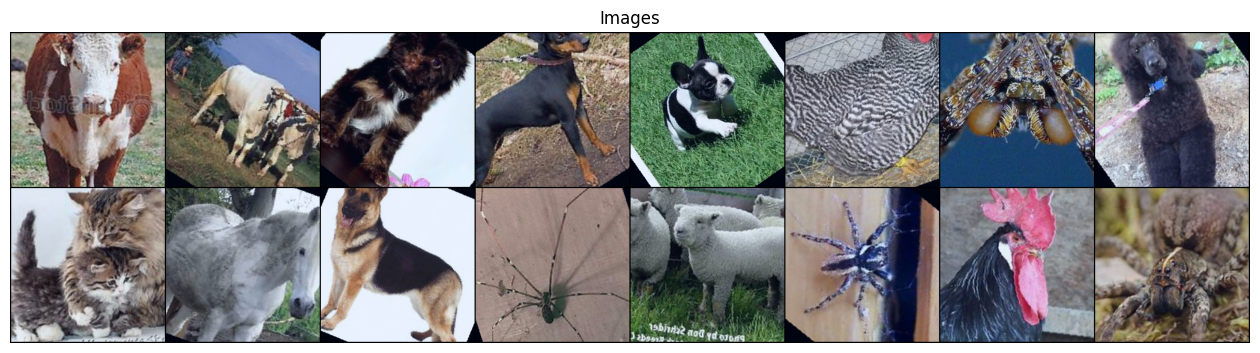

In [11]:
PlotSamples(train_dataloader)

In [12]:
#The above is giving 16 images because we wrote 16 as batch size

In [13]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3), nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(16, 32, kernel_size=3), nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3), nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size=3), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(2,2),

        ).to(device)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(4096, 256),
            nn.ReLU(),

            nn.Dropout(0.5),
            nn.Linear(256, 10)
        ).to(device)

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x


model = MyModel().to(device)
summary(model, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
              ReLU-2         [-1, 16, 254, 254]               0
            Conv2d-3         [-1, 16, 252, 252]           2,320
              ReLU-4         [-1, 16, 252, 252]               0
         MaxPool2d-5         [-1, 16, 126, 126]               0
            Conv2d-6         [-1, 32, 124, 124]           4,640
              ReLU-7         [-1, 32, 124, 124]               0
            Conv2d-8         [-1, 32, 122, 122]           9,248
              ReLU-9         [-1, 32, 122, 122]               0
        MaxPool2d-10           [-1, 32, 61, 61]               0
           Conv2d-11           [-1, 64, 59, 59]          18,496
             ReLU-12           [-1, 64, 59, 59]               0
           Conv2d-13           [-1, 64, 57, 57]          36,928
             ReLU-14           [-1, 64,

Convolutional Layer Parameter Calculation
For each 2D convolutional layer (Conv2d):

Weights:
(kernel_height
×
kernel_width
×
input_channels
×
output_channels)
(kernel_height×kernel_width×input_channels×output_channels)
Biases:
(out_channels)
(out_channels)
Convolutional Layers
First Conv2d Layer: Conv2d(3, 16, kernel_size=3)

Input channels: 3
Output channels: 16
Kernel size:
3
×
3
3×3
Weight parameters:
3
×
3
×
3
×
16
=
432
3×3×3×16=432
Bias parameters:
16
16
Total parameters:
432
+
16
=
448
432+16=448
Second Conv2d Layer: Conv2d(16, 16, kernel_size=3)

Input channels: 16
Output channels: 16
Kernel size:
3
×
3
3×3
Weight parameters:
3
×
3
×
16
×
16
=
2304
3×3×16×16=2304
Bias parameters:
16
16
Total parameters:
2304
+
16
=
2320
2304+16=2320
Third Conv2d Layer: Conv2d(16, 32, kernel_size=3)

Input channels: 16
Output channels: 32
Kernel size:
3
×
3
3×3
Weight parameters:
3
×
3
×
16
×
32
=
4608
3×3×16×32=4608
Bias parameters:
32
32
Total parameters:
4608
+
32
=
4640
4608+32=4640
Fourth Conv2d Layer: Conv2d(32, 32, kernel_size=3)

Input channels: 32
Output channels: 32
Kernel size:
3
×
3
3×3
Weight parameters:
3
×
3
×
32
×
32
=
9216
3×3×32×32=9216
Bias parameters:
32
32
Total parameters:
9216
+
32
=
9248
9216+32=9248
Fifth Conv2d Layer: Conv2d(32, 64, kernel_size=3)

Input channels: 32
Output channels: 64
Kernel size:
3
×
3
3×3
Weight parameters:
3
×
3
×
32
×
64
=
18432
3×3×32×64=18432
Bias parameters:
64
64
Total parameters:
18432
+
64
=
18496
18432+64=18496
Sixth Conv2d Layer: Conv2d(64, 64, kernel_size=3)

Input channels: 64
Output channels: 64
Kernel size:
3
×
3
3×3
Weight parameters:
3
×
3
×
64
×
64
=
36864
3×3×64×64=36864
Bias parameters:
64
64
Total parameters:
36864
+
64
=
36928
36864+64=36928
Seventh Conv2d Layer: Conv2d(64, 128, kernel_size=3)

Input channels: 64
Output channels: 128
Kernel size:
3
×
3
3×3
Weight parameters:
3
×
3
×
64
×
128
=
73728
3×3×64×128=73728
Bias parameters:
128
128
Total parameters:
73728
+
128
=
73856
73728+128=73856
Eighth Conv2d Layer: Conv2d(128, 128, kernel_size=3)

Input channels: 128
Output channels: 128
Kernel size:
3
×
3
3×3
Weight parameters:
3
×
3
×
128
×
128
=
147456
3×3×128×128=147456
Bias parameters:
128
128
Total parameters:
147456
+
128
=
147584
147456+128=147584
Ninth Conv2d Layer: Conv2d(128, 256, kernel_size=3)

Input channels: 128
Output channels: 256
Kernel size:
3
×
3
3×3
Weight parameters:
3
×
3
×
128
×
256
=
294912
3×3×128×256=294912
Bias parameters:
256
256
Total parameters:
294912
+
256
=
295168
294912+256=295168
Tenth Conv2d Layer: Conv2d(256, 256, kernel_size=3)

Input channels: 256
Output channels: 256
Kernel size:
3
×
3
3×3
Weight parameters:
3
×
3
×
256
×
256
=
589824
3×3×256×256=589824
Bias parameters:
256
256
Total parameters:
589824
+
256
=
590080
589824+256=590080
Fully Connected Layers (Classifier)
After the convolutional layers, the output is flattened, leading to the fully connected layers.

First Fully Connected Layer: Linear(4096, 256)

Input features: 4096
Output features: 256
Weight parameters:
4096
×
256
=
1048576
4096×256=1048576
Bias parameters:
256
256
Total parameters:
1048576
+
256
=
1048832
1048576+256=1048832
Second Fully Connected Layer: Linear(256, 10)

Input features: 256
Output features: 10
Weight parameters:
256
×
10
=
2560
256×10=2560
Bias parameters:
10
10
Total parameters:
2560
+
10
=
2570
2560+10=2570

In [18]:
n_batches_to_print = 5  # Set the number of batches you want to print

for i, batch in enumerate(train_dataloader, 1):
    minshape = batch[0].shape  # Get shape of the batch of images
    target_shape = batch[1].shape  # Get shape of the corresponding targets

    # Print the shapes for the first n batches
    if i <= n_batches_to_print:
        print(f"Batch {i}:")
        print(f"Input shape: {minshape}")  # Print the shape of the input images
        print(f"Target shape: {target_shape}")  # Print the shape of the target labels
    else:
        break  # Stop printing after the first n batches


Exception ignored in: 

Batch 1:
Input shape: torch.Size([16, 3, 256, 256])
Target shape: torch.Size([16])


<function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Batch 2:
Input shape: torch.Size([16, 3, 256, 256])
Target shape: torch.Size([16])
Batch 3:
Input shape: torch.Size([16, 3, 256, 256])
Target shape: torch.Size([16])
Batch 4:
Input shape: torch.Size([16, 3, 256, 256])
Target shape: torch.Size([16])
Batch 5:
Input shape: torch.Size([16, 3, 256, 256])
Target shape: torch.Size([16])


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


In [19]:
import os
from torchvision import datasets

# Specify the dataset path
dataset_path = 'BasicCNN_Pytorch/raw-img'

# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=dataset_path)

# Get the target labels
targets = dataset.targets  # This will give you a list of class indices

# Calculate the number of unique classes
unique_classes = set(targets)

# Output the number of different target sizes (classes)
print(f"Total number of different target sizes (classes): {len(unique_classes)}")
print(f"Classes: {unique_classes}")


Total number of different target sizes (classes): 10
Classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [21]:
from collections import Counter

# Set the number of batches to print
n_batches_to_print = 5  # Change this value to print more or fewer batches

for i, batch in enumerate(train_dataloader, 1):
    mininput = batch[0].to(device)  # Get batch of images from our train dataloader
    target = batch[1].to(device)     # Get the corresponding target (0, 1, 2,..., 9)

    minshape = mininput.shape  # Get shape of the batch of images
    target_shape = target.shape  # Get shape of the corresponding targets

    # Count the occurrences of each class in the target
    class_counts = Counter(target.cpu().numpy())

    # Print the shapes and class counts for the first n_batches_to_print
    if i <= n_batches_to_print:
        print(f"Batch {i}:")
        print(f"Input shape: {minshape}")  # Print the shape of the input images
        print(f"Target shape: {target_shape}")  # Print the shape of the target labels

        # Print the counts of each class
        print("Class counts:")
        for class_id in range(10):  # Assuming class IDs are from 0 to 9
            print(f"Class {class_id}: {class_counts[class_id]}")
        print()  # Print a new line for better readability
    else:
        break  # Stop printing after the first n batches


Batch 1:
Input shape: torch.Size([16, 3, 256, 256])
Target shape: torch.Size([16])
Class counts:
Class 0: 5
Class 1: 1
Class 2: 0
Class 3: 0
Class 4: 2
Class 5: 1
Class 6: 2
Class 7: 1
Class 8: 4
Class 9: 0

Batch 2:
Input shape: torch.Size([16, 3, 256, 256])
Target shape: torch.Size([16])
Class counts:
Class 0: 1
Class 1: 1
Class 2: 0
Class 3: 2
Class 4: 2
Class 5: 3
Class 6: 2
Class 7: 2
Class 8: 2
Class 9: 1

Batch 3:
Input shape: torch.Size([16, 3, 256, 256])
Target shape: torch.Size([16])
Class counts:
Class 0: 0
Class 1: 2
Class 2: 1
Class 3: 1
Class 4: 2
Class 5: 0
Class 6: 2
Class 7: 2
Class 8: 5
Class 9: 1

Batch 4:
Input shape: torch.Size([16, 3, 256, 256])
Target shape: torch.Size([16])
Class counts:
Class 0: 5
Class 1: 0
Class 2: 0
Class 3: 1
Class 4: 4
Class 5: 0
Class 6: 2
Class 7: 1
Class 8: 3
Class 9: 0

Batch 5:
Input shape: torch.Size([16, 3, 256, 256])
Target shape: torch.Size([16])
Class counts:
Class 0: 0
Class 1: 2
Class 2: 1
Class 3: 2
Class 4: 1
Class 5: 2
Class

In [22]:
'''What does this above signify , bacthes are made with more than 1 image of one class and 0 of other , it increases randomness in training better for random test cases'''

'What does this above signify , bacthes are made with more than 1 image of one class and 0 of other , it increases randomness in training better for random test cases'

In [23]:
def Train(epoch, print_every=50):
    total_loss = 0
    start_time = time()

    accuracy = []

    for i, batch in enumerate(train_dataloader, 1):
        minput = batch[0].to(device) # Get batch of images from our train dataloader
        target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas






        moutput = model(minput) # output by our model

        loss = criterion(moutput, target) # compute cross entropy loss
        total_loss += loss.item()

        optimizer.zero_grad() # Clear the gradients if exists. (Gradients are used for back-propogation.)
        loss.backward() # Back propogate the losses
        optimizer.step() # Update Model parameters

        argmax = moutput.argmax(dim=1) # Get the class index with maximum probability predicted by the model
        accuracy.append((target==argmax).sum().item() / target.shape[0]) # calculate accuracy by comparing to target tensor

        if i%print_every == 0:
            print('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
                epoch, i, len(train_dataloader), loss.item(), sum(accuracy)/len(accuracy), time()-start_time
            ))

    return total_loss / len(train_dataloader) # Returning Average Training Loss

In [24]:
def Test(epoch):
    total_loss = 0
    start_time = time()

    accuracy = []

    with torch.no_grad(): # disable calculations of gradients for all pytorch operations inside the block
        for i, batch in enumerate(test_dataloader):
            minput = batch[0].to(device) # Get batch of images from our test dataloader
            target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas
            moutput = model(minput) # output by our model

            loss = criterion(moutput, target) # compute cross entropy loss
            total_loss += loss.item()


            # To get the probabilities for different classes we need to apply a softmax operation on moutput
            argmax = moutput.argmax(dim=1) # Find the index(0, 1 or 2) with maximum score (which denotes class with maximum probability)
            accuracy.append((target==argmax).sum().item() / target.shape[0]) # Find the accuracy of the batch by comparing it with actual targets

    print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(test_dataloader), sum(accuracy)/len(accuracy), time()-start_time
    ))
    return total_loss/len(test_dataloader) # Returning Average Testing Loss

In [25]:
lr = 0.0001
model = MyModel().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [26]:
Test(0)

train_loss = []
test_loss = []

for epoch in range(1, 51):
    train_loss.append(Train(epoch,200))
    test_loss.append(Test(epoch))

    print('\n')

    if epoch % 10 == 0:
        torch.save(model, 'model_'+str(epoch)+'.pth')

Epoch: [0], Test Loss: 2.2992, Accuracy: 0.17, Time: 27.96 sec
Epoch: [1]/(200/1313), Train Loss: 2.3705, Accuracy: 0.18, Time: 17.53 sec
Epoch: [1]/(400/1313), Train Loss: 2.3004, Accuracy: 0.18, Time: 35.50 sec
Epoch: [1]/(600/1313), Train Loss: 2.0267, Accuracy: 0.18, Time: 55.76 sec
Epoch: [1]/(800/1313), Train Loss: 2.3547, Accuracy: 0.18, Time: 73.41 sec
Epoch: [1]/(1000/1313), Train Loss: 2.1406, Accuracy: 0.18, Time: 91.43 sec
Epoch: [1]/(1200/1313), Train Loss: 2.3100, Accuracy: 0.18, Time: 110.39 sec
Epoch: [1], Test Loss: 2.2155, Accuracy: 0.19, Time: 26.95 sec


Epoch: [2]/(200/1313), Train Loss: 2.2929, Accuracy: 0.21, Time: 17.88 sec
Epoch: [2]/(400/1313), Train Loss: 2.2111, Accuracy: 0.23, Time: 36.03 sec
Epoch: [2]/(600/1313), Train Loss: 1.8288, Accuracy: 0.25, Time: 56.77 sec
Epoch: [2]/(800/1313), Train Loss: 2.4776, Accuracy: 0.26, Time: 73.86 sec
Epoch: [2]/(1000/1313), Train Loss: 1.6819, Accuracy: 0.27, Time: 91.98 sec
Epoch: [2]/(1200/1313), Train Loss: 2.2968,

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch: [40]/(600/1313), Train Loss: 0.5945, Accuracy: 0.78, Time: 56.38 sec


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: [40]/(800/1313), Train Loss: 1.1476, Accuracy: 0.78, Time: 74.22 sec
Epoch: [40]/(1000/1313), Train Loss: 0.4103, Accuracy: 0.78, Time: 92.30 sec
Epoch: [40]/(1200/1313), Train Loss: 0.6952, Accuracy: 0.78, Time: 109.74 sec
Epoch: [40], Test Loss: 0.8904, Accuracy: 0.73, Time: 25.91 sec


Epoch: [41]/(200/1313), Train Loss: 0.5859, Accuracy: 0.80, Time: 17.60 sec
Epoch: [41]/(400/1313), Train Loss: 0.5100, Accuracy: 0.79, Time: 35.48 sec


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: [41]/(600/1313), Train Loss: 0.9334, Accuracy: 0.79, Time: 55.43 sec
Epoch: [41]/(800/1313), Train Loss: 0.9717, Accuracy: 0.79, Time: 73.20 sec
Epoch: [41]/(1000/1313), Train Loss: 0.6483, Accuracy: 0.79, Time: 92.89 sec
Epoch: [41]/(1200/1313), Train Loss: 0.8344, Accuracy: 0.79, Time: 110.28 sec
Epoch: [41], Test Loss: 0.7994, Accuracy: 0.74, Time: 24.15 sec


Epoch: [42]/(200/1313), Train Loss: 0.7527, Accuracy: 0.79, Time: 18.15 sec


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

Epoch: [42]/(400/1313), Train Loss: 0.3652, Accuracy: 0.79, Time: 38.38 sec
Epoch: [42]/(600/1313), Train Loss: 0.8579, Accuracy: 0.79, Time: 57.48 sec
Epoch: [42]/(800/1313), Train Loss: 1.0376, Accuracy: 0.79, Time: 74.48 sec
Epoch: [42]/(1000/1313), Train Loss: 0.2012, Accuracy: 0.79, Time: 92.70 sec
Epoch: [42]/(1200/1313), Train Loss: 0.6630, Accuracy: 0.79, Time: 111.48 sec


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
Exception ignored in: <function _Multi

Epoch: [42], Test Loss: 0.8354, Accuracy: 0.73, Time: 27.31 sec




Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch: [43]/(200/1313), Train Loss: 1.1992, Accuracy: 0.80, Time: 17.93 sec


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    self._shutdown_workers()
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError    if w.is_alive():
: can only test a child process  File "/usr/lib/p

Epoch: [43]/(400/1313), Train Loss: 0.9001, Accuracy: 0.80, Time: 36.86 sec
Epoch: [43]/(600/1313), Train Loss: 0.8863, Accuracy: 0.80, Time: 57.86 sec
Epoch: [43]/(800/1313), Train Loss: 1.0539, Accuracy: 0.80, Time: 75.07 sec
Epoch: [43]/(1000/1313), Train Loss: 0.2746, Accuracy: 0.80, Time: 93.09 sec
Epoch: [43]/(1200/1313), Train Loss: 0.9835, Accuracy: 0.80, Time: 110.71 sec


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: [43], Test Loss: 0.8105, Accuracy: 0.74, Time: 27.31 sec




Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>    
if w.is_alive():Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

Epoch: [44]/(200/1313), Train Loss: 0.4723, Accuracy: 0.81, Time: 18.91 sec
Epoch: [44]/(400/1313), Train Loss: 0.4862, Accuracy: 0.81, Time: 36.79 sec
Epoch: [44]/(600/1313), Train Loss: 1.0852, Accuracy: 0.80, Time: 55.69 sec
Epoch: [44]/(800/1313), Train Loss: 1.0553, Accuracy: 0.81, Time: 73.22 sec
Epoch: [44]/(1000/1313), Train Loss: 0.2071, Accuracy: 0.80, Time: 92.82 sec
Epoch: [44]/(1200/1313), Train Loss: 0.8353, Accuracy: 0.80, Time: 110.41 sec


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
<function _Multi

Epoch: [44], Test Loss: 0.8254, Accuracy: 0.74, Time: 25.63 sec




Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: [45]/(200/1313), Train Loss: 0.3679, Accuracy: 0.82, Time: 20.58 sec
Epoch: [45]/(400/1313), Train Loss: 0.5626, Accuracy: 0.81, Time: 38.95 sec
Epoch: [45]/(600/1313), Train Loss: 0.6548, Accuracy: 0.81, Time: 57.78 sec
Epoch: [45]/(800/1313), Train Loss: 1.1904, Accuracy: 0.81, Time: 74.94 sec
Epoch: [45]/(1000/1313), Train Loss: 0.5243, Accuracy: 0.81, Time: 92.94 sec
Epoch: [45]/(1200/1313), Train Loss: 0.7255, Accuracy: 0.81, Time: 111.75 sec


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionErrorTraceback (most recent call last):
:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
can only test a child process    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: [45], Test Loss: 0.8213, Accuracy: 0.74, Time: 27.40 sec




Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c6abc92d360>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: [46]/(200/1313), Train Loss: 0.2343, Accuracy: 0.81, Time: 19.31 sec
Epoch: [46]/(400/1313), Train Loss: 0.6734, Accuracy: 0.81, Time: 38.34 sec
Epoch: [46]/(600/1313), Train Loss: 0.6949, Accuracy: 0.81, Time: 58.50 sec
Epoch: [46]/(800/1313), Train Loss: 0.9792, Accuracy: 0.81, Time: 75.49 sec
Epoch: [46]/(1000/1313), Train Loss: 0.3360, Accuracy: 0.81, Time: 93.68 sec
Epoch: [46]/(1200/1313), Train Loss: 0.4023, Accuracy: 0.81, Time: 111.08 sec
Epoch: [46], Test Loss: 0.7706, Accuracy: 0.75, Time: 26.30 sec


Epoch: [47]/(200/1313), Train Loss: 0.3657, Accuracy: 0.82, Time: 17.67 sec
Epoch: [47]/(400/1313), Train Loss: 0.5108, Accuracy: 0.82, Time: 35.73 sec
Epoch: [47]/(600/1313), Train Loss: 0.6852, Accuracy: 0.81, Time: 55.40 sec
Epoch: [47]/(800/1313), Train Loss: 0.9115, Accuracy: 0.81, Time: 73.43 sec
Epoch: [47]/(1000/1313), Train Loss: 0.5504, Accuracy: 0.81, Time: 91.84 sec
Epoch: [47]/(1200/1313), Train Loss: 0.5775, Accuracy: 0.81, Time: 109.35 sec
Epoch: [47], Tes

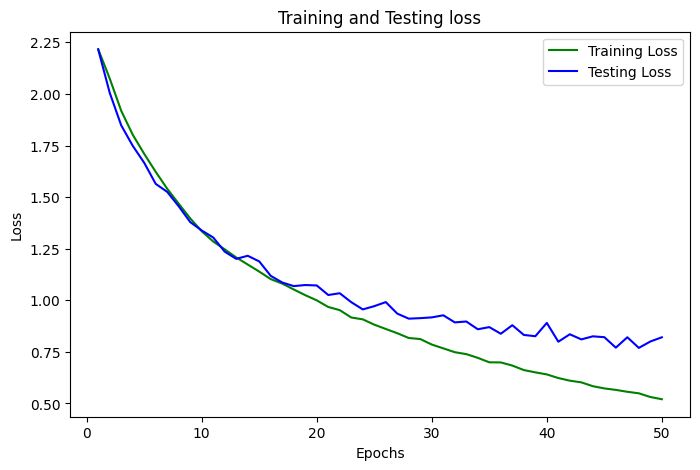

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_loss)+1), train_loss, 'g', label='Training Loss')
plt.plot(range(1, len(test_loss)+1), test_loss, 'b', label='Testing Loss')

plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel",
}

translate = {x:translate[x] for x in train_dataloader.dataset.dataset.classes}

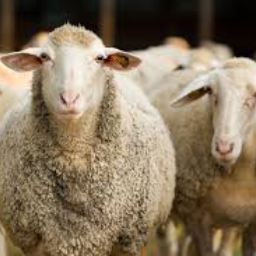

sheep : 97 % 




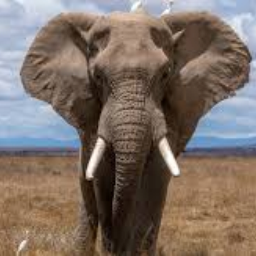

elephant : 47 % 




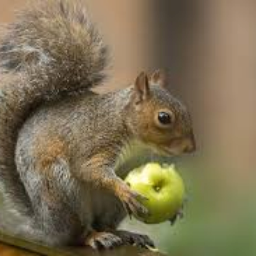

squirrel : 93 % 




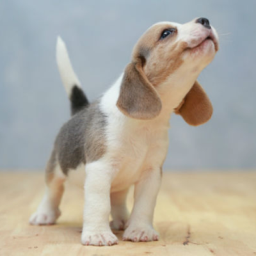

dog : 81 % 




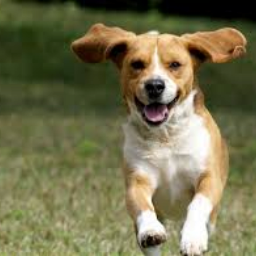

dog : 100 % 




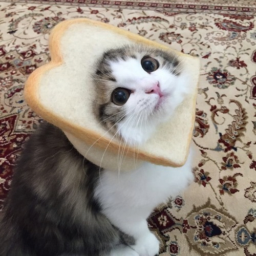

cat : 71 % 




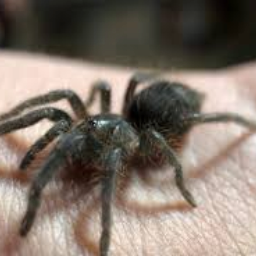

spider : 98 % 




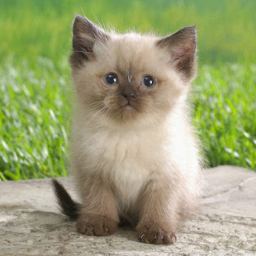

dog : 81 % 




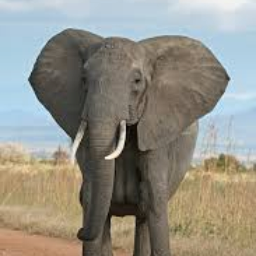

elephant : 99 % 




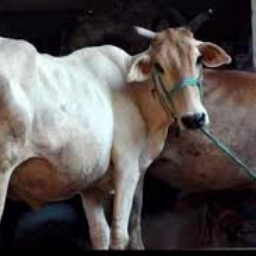

dog : 57 % 




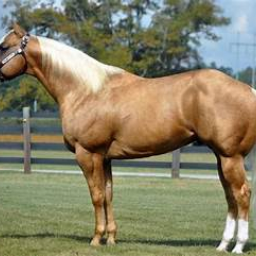

horse : 96 % 




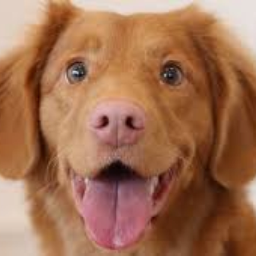

dog : 99 % 




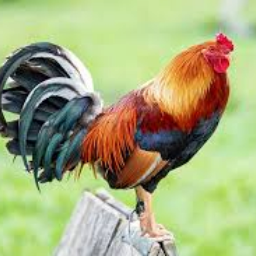

chicken : 97 % 




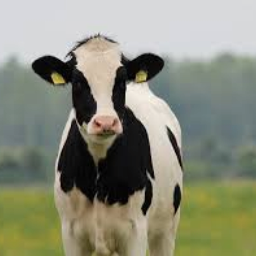

dog : 49 % 




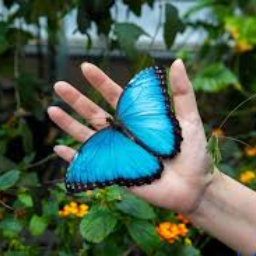

butterfly : 30 % 




In [29]:
# # Uncomment the below two lines if you want to use the pre trained model for 100 epoch
# model = torch.load('BasicCNN_Pytorch/model_100.pth', map_location=device)
# model.eval()

denormalize = transforms.Compose([
    transforms.Normalize(mean = -mean/std, std = 1./std),
    transforms.ToPILImage()
])


with torch.no_grad():

    for impath in os.listdir('BasicCNN_Pytorch/test_images/'):
        try:
            image = Image.open(f'BasicCNN_Pytorch/test_images/{impath}')
        except:
            continue

        image = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])(image)

        image_tensor = image.view(1,3,256,256).to(device)

        moutput = model(image_tensor)
        moutput = nn.Softmax(dim=1)(moutput)[0]*100

        idx = moutput.argmax().data.item()
        oclass = list(translate.keys())[idx]
        moutput = moutput.int().data.cpu().numpy()

        display(denormalize(image))
        print(translate[oclass], ':', moutput[idx], '%', '\n\n')

model.train()
pass